In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import wbdata as wb
import sys
#!{sys.executable} -m pip install --user geopandas
import geopandas as gpd
import json as json
from bokeh.io import output_notebook, show, curdoc, push_notebook, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, CategoricalColorMapper, LinearColorMapper, ContinuousColorMapper, ColorBar, HoverTool, FuncTickFormatter, NumeralTickFormatter, SingleIntervalTicker, Slider, CustomJS
from bokeh.palettes import brewer 
from bokeh.layouts import column, widgetbox
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
#from bokeh.resources import INLINE
#import bokeh.io
#bokeh.io.output_notebook(INLINE)
import statsmodels.formula.api as sm
#import sys
#!{sys.executable} -m pip install ipywidgets
import ipywidgets as widgets
from ipywidgets.embed import embed_minimal_html
output_notebook()

Loading BokehJS ...

In [3]:
#wb.search_indicators("country")
indicators = {"ny.gdp.pcap.pp.cd" : "gdp"} #I use GDP per capita, PPP (in current US dollars) (also called real GDP)
rename = {"Congo, Dem. Rep.": "Democratic Republic of the Congo", "Congo, Rep.": "Republic of the Congo", "Cote d'Ivoire": "Ivory Coast", "Czech Republic": "Czechia",
          "Egypt, Arab Rep.": "Egypt", "Eswatini": "eSwatini", "Gambia, The": "Gambia", "Iran, Islamic Rep.": "Iran", "Korea, Rep.": "South Korea", "Kyrgyz Republic": "Kyrgyzstan",
          "Lao PDR": "Laos", "North Macedonia": "Macedonia", "Russian Federation": "Russia", "Serbia": "Republic of Serbia", "Slovak Republic": "Slovakia",
          "Syrian Arab Republic": "Syria", "Tanzania": "United Republic of Tanzania", "United States": "United States of America", "Venezuela, RB": "Venezuela", "Yemen, Rep.": "Yemen"}

dfgdp_data = wb.get_dataframe(indicators, country="all")
dfgdp_data.reset_index(inplace = True)
dfgdp_data["date"] = pd.to_numeric(dfgdp_data["date"], downcast="integer")
dfgdp_data.at[9150:9210, "country"] = "North Korea"

#Add rows for countries Palestine, Somaliland and Western Sahara which are not recognized by the Worldbank:
for i in np.arange(0,61): #Every country has 61 rows (years 1960 to 2020)
    dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
    dfgdp_data.loc[[len(dfgdp_data)-1], "country"] = "Palestine"
    dfgdp_data.loc[[len(dfgdp_data)-1], "date"] = 2020 - i 

for i in np.arange(0,61): #Every country has 61 rows (years 1960 to 2020)
    dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
    dfgdp_data.loc[[len(dfgdp_data)-1], "country"] = "Somaliland"
    dfgdp_data.loc[[len(dfgdp_data)-1], "date"] = 2020 - i 

for i in np.arange(0,61):
    dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) 
    dfgdp_data.loc[[len(dfgdp_data)-1], "country"] = "Western Sahara"
    dfgdp_data.loc[[len(dfgdp_data)-1], "date"] = 2020 - i

#Rename countries to match data
dfgdp_data["country"] = dfgdp_data["country"].replace(rename)

#Add log_gdp to dataframe
dfgdp_data["log_gdp"] = np.log(dfgdp_data["gdp"])
#Add growth_gdp and growth_log_gdp to dataframe
dfgdp_data["growth_gdp"] = (dfgdp_data["gdp"] - dfgdp_data["gdp"].shift(-1)) / dfgdp_data["gdp"].shift(-1)
dfgdp_data["growth_log_gdp"] = (dfgdp_data["log_gdp"] - dfgdp_data["log_gdp"].shift(-1)) / dfgdp_data["log_gdp"].shift(-1)

dfgdp_data["gdp_shift"] = dfgdp_data["gdp"].shift(-1)
dfgdp_data["log_gdp_shift"] = dfgdp_data["log_gdp"].shift(-1)

dfgdp_data.head()

#gdp_data.to_csv('Data/worldbank_data_gdp_per_capita_ppp.csv')

<ipython-input-3-3a349b0c6faa>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
<ipython-input-3-3a349b0c6faa>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
<ipython-input-3-3a349b0c6faa>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True)


,country,date,gdp,log_gdp,growth_gdp,growth_log_gdp,gdp_shift,log_gdp_shift
0,Arab World,2020.0,NaN,NaN,NaN,NaN,15256.376720,9.632753
1,Arab World,2019.0,15256.376720,9.632753,0.018086,0.001864,14985.352890,9.614829
2,Arab World,2018.0,14985.352890,9.614829,0.029046,0.002987,14562.367966,9.586196
3,Arab World,2017.0,14562.367966,9.586196,0.038251,0.003931,14025.865608,9.548658
4,Arab World,2016.0,14025.865608,9.548658,-0.040550,-0.004316,14618.653949,9.590054


In [6]:
dflandlocked = pd.read_csv('Data/landlocked.csv', sep = ';')
#dflandlocked.head()

dfgdp = dfgdp_data.assign(landlocked = dfgdp_data["country"].isin(dflandlocked["Country"]).astype(bool)) #Where dataframes overlap, landlocked = 1, otherwise landlocked = 0
dfgdp["landlocked"] = dfgdp["landlocked"].replace({True: "Yes", False: "No"})
#Previously first line was int instead of bool
dfgdp.tail()

,country,date,gdp,log_gdp,growth_gdp,growth_log_gdp,gdp_shift,log_gdp_shift,landlocked
16282,Western Sahara,1964.0,NaN,NaN,NaN,NaN,NaN,NaN,No
16283,Western Sahara,1963.0,NaN,NaN,NaN,NaN,NaN,NaN,No
16284,Western Sahara,1962.0,NaN,NaN,NaN,NaN,NaN,NaN,No
16285,Western Sahara,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,No
16286,Western Sahara,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,No


In [7]:
worldmap = "Data/ne_110m_admin_0_countries.shp"
worldmap = gpd.read_file(worldmap)[['ADMIN', 'ADM0_A3', 'geometry']]
worldmap.columns = ['country', 'country_code', 'geometry']
worldmap = worldmap.drop(worldmap.index[159]) #Remove Antarctica as there is no available gdp data, and it takes up a lot of space on the map
#worldmap.head()

dfgdp_merged = worldmap.merge(dfgdp, how="left", on="country")
dfgdp_merged.fillna("NaN", inplace = True)
dfgdp_merged.head()

,country,country_code,geometry,date,gdp,log_gdp,growth_gdp,growth_log_gdp,gdp_shift,log_gdp_shift,landlocked
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020.0,NaN,NaN,NaN,NaN,14289.960502,9.567313,No
1,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2019.0,14289.960502,9.567313,0.007501,0.000782,14183.563896,9.559839,No
2,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2018.0,14183.563896,9.559839,0.056164,0.005749,13429.315918,9.505195,No
3,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2017.0,13429.315918,9.505195,0.063118,0.006481,12632.013532,9.443990,No
4,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2016.0,12632.013532,9.443990,0.017691,0.001860,12412.422182,9.426453,No


In [6]:
#pd.set_option("max_rows", None)
#worldmap

In [8]:
dfgdp_merged_2015 = dfgdp_merged[dfgdp_merged["date"] == 2015]
#dfgdp_merged_2015.head()
dfgdp_merged_2015_json = json.loads(dfgdp_merged_2015.to_json())
#dfgdp_2015.coordinate.__geo_interface__
dfgdp_merged_2015_json_data = json.dumps(dfgdp_merged_2015_json)

In [9]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = dfgdp_merged_2015_json_data)
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = CategoricalColorMapper(palette = ['red','blue'], factors = ("Yes", "No"), nan_color = "lightgrey")
#Create figure object.
p = figure(title = 'Landlocked Countries', plot_height = 600 , plot_width = 1000,
          tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'landlocked', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

In [10]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = dfgdp_merged_2015_json_data)
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = NumeralTickFormatter(format = "$0,")
#formatter = FuncTickFormatter(code = """
#    var data = {'0': '0$', '5000': '5,000$', '10000':'10,000$', '15000':'15,000$', '20000':'20,000$', '25000':'25,000$',
#            '30000':'30,000$','35000':'35,000$', '40000': '40,000$', '45000': '>45,000$'}
#    return data[tick]
#""")
#Create color bar. 
color_bar = ColorBar(color_mapper = color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ (2015)", plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('GDP per capita', '$@gdp{0,0}'), ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

In [11]:
def data_slider(year):
    dfgdp_selected_year = dfgdp[dfgdp["date"] == year]
    dfgdp_merged_selected_year = worldmap.merge(dfgdp_selected_year, how="left", on="country")
    dfgdp_merged_selected_year.fillna("NaN", inplace = True)
    dfgdp_merged_selected_year_json = json.loads(dfgdp_merged_selected_year.to_json())
    data_slider = json.dumps(dfgdp_merged_selected_year_json)
    return data_slider


In [12]:
#To get output to HTML file use following in anaconda prompt:
#jupyter nbconvert --to html Documents\Python\AEA_Assignment_home.ipynb

#Initial year (default year that is selected by slider)
year_initial = 2019
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = data_slider(year_initial))
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = NumeralTickFormatter(format = "$0,")
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ ({})".format(year_initial), plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Define slider
#slider = Slider(title = "Year", start = 1990, end = 2015, value = year_initial) 
#Define callback function for slider to select different years
def callback(Year = year_initial):
    #year = slider.value
    geosource.geojson = data_slider(Year) #new_data = data_slider(year)
    #geosource.geojson = new_data
    p.title.text = "GDP per capita in $ ({})".format(Year)
    push_notebook()
#slider.on_change("value", callback)
#And add slider to plot p
#layout = column(widgetbox(slider), p)
#curdoc().add_root(layout)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'),
                            ('GDP per capita', '$@gdp{0,0}'),
                            ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.

#Display figure.
show(p, notebook_handle = True)
slider = widgets.IntSlider(value = year_initial, min = 1990, max = 2019)
widgets.interact(callback, Year = slider)

#Save widget so that it appears after a kernal restart, slider does not update plot without rerunning this cell!!
def save_widgets ():
    display(
        HTML('<script>Jupyter.menubar.actions._actions["widgets:save-widget"].handler()</script>'))
    
#embed_minimal_html('export.html', views=[slider], title='Widgets export')

interactive(children=(IntSlider(value=2019, description='Year', max=2019, min=1990), Output()), _dom_classes=(…

In [13]:
#To get output to HTML file use following in anaconda prompt:
#jupyter nbconvert --to html Documents\Python\AEA_Assignment_home.ipynb

#Initial year (default year that is selected by slider)
year_initial = 2019
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = data_slider(year_initial))
#Define a sequential multi-hue color palette.
palette = brewer["RdYlGn"][10]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -0.15, high = 0.15, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 0.03)
formatter = NumeralTickFormatter(format = "0%")
#formatter = FuncTickFormatter(code = """
#    var data = {'0': '0$', '5000': '5,000$', '10000':'10,000$', '15000':'15,000$', '20000':'20,000$', '25000':'25,000$',
#                '30000':'30,000$','35000':'35,000$', '40000': '40,000$', '45000': '>45,000$'}
#    return data[tick]
#""")
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, ticker = ticker_labels, formatter = formatter,
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita growth in % ({})".format(year_initial), plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'growth_gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Define slider
#slider = Slider(title = "Year", start = 1990, end = 2015, value = year_initial) 
#Define callback function for slider to select different years
def callback(Year = year_initial):
    #year = slider.value
    geosource.geojson = data_slider(Year) #new_data = data_slider(year)
    #geosource.geojson = new_data
    p.title.text = "GDP per capita growth in % ({})".format(Year)
    push_notebook()
#slider.on_change("value", callback)
#And add slider to plot p
#layout = column(widgetbox(slider), p)
#curdoc().add_root(layout)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'),
                            ('GDP per capita growth', '@growth_gdp{0:3.1f%}'),
                            ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.

#Display figure.
show(p, notebook_handle = True)
slider = widgets.IntSlider(value = year_initial, min = 1991, max = 2019)
widgets.interact(callback, Year = slider)

#Save widget so that it appears after a kernal restart, slider does not update plot without rerunning this cell!!
def save_widgets ():
    display(
        HTML('<script>Jupyter.menubar.actions._actions["widgets:save-widget"].handler()</script>'))
    
#embed_minimal_html('export.html', views=[slider], title='Widgets export')

interactive(children=(IntSlider(value=2019, description='Year', max=2019, min=1991), Output()), _dom_classes=(…

In [19]:
#Try using only Bokeh (no interactive plot)

#Initial year (default year that is selected by slider)
year_initial = 2019
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = data_slider(year_initial))
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = NumeralTickFormatter(format = "$0,")
#formatter = FuncTickFormatter(code = """
#    var data = {'0': '0$', '5000': '5,000$', '10000':'10,000$', '15000':'15,000$', '20000':'20,000$', '25000':'25,000$',
#                '30000':'30,000$','35000':'35,000$', '40000': '40,000$', '45000': '>45,000$'}
#    return data[tick]
#""")
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ ({})".format(year_initial), plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Define slider
slider = Slider(title = "Year", start = 1990, end = 2015, value = year_initial) 
#Define callback function for slider to select different years
def callback(attr, new, old):
    year = slider.value
    geosource.geojson = data_slider(Year) #new_data = data_slider(year)
    #geosource.geojson = new_data
    p.title.text = "GDP per capita in $ (%year)"
    #push_notebook()
slider.on_change("value", callback)
#And add slider to plot p
layout = column(widgetbox(slider), p)
curdoc().add_root(layout)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'),
                            ('GDP per capita', '$@gdp{0,0}'),
                            ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.

#Display figure.
show(layout)
#slider = widgets.IntSlider(value = year_initial, min = 1990, max = 2019)
#widgets.interact(callback, Year = slider)

#Save widget so that it appears after a kernal restart, slider does not update plot without rerunning this cell!!
#def save_widgets ():
#    display(
#        HTML('<script>Jupyter.menubar.actions._actions["widgets:save-widget"].handler()</script>'))
    
#embed_minimal_html('export.html', views=[slider], title='Widgets export')

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [15]:
eu_states = {"Luxembourg", "Czechia", "Austria", "Slovakia", "Hungary"} #Landlocked countries that are EU member states
data1990 = dfgdp[(dfgdp["date"] > 1994) & (dfgdp["date"] < 2020)]
#data1990 = data1990[(data1990["country"] != "Luxembourg") | (data1990["country"] != "Austria")]
data1990 = data1990[~data1990["country"].isin(eu_states)]
factor = data1990["date"].astype(object)
lm2015 = sm.ols(formula="growth_gdp ~ landlocked + factor", data=data1990).fit()
print(lm2015.summary())
data1990.head()

                            OLS Regression Results                            
Dep. Variable:             growth_gdp   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     22.95
Date:                Tue, 05 Jan 2021   Prob (F-statistic):          8.69e-100
Time:                        17:05:52   Log-Likelihood:                 8235.5
No. Observations:                5743   AIC:                        -1.642e+04
Df Residuals:                    5717   BIC:                        -1.625e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0441      0.00

,country,date,gdp,log_gdp,growth_gdp,growth_log_gdp,gdp_shift,log_gdp_shift,landlocked
1,Arab World,2019.0,15256.376720,9.632753,0.018086,0.001864,14985.352890,9.614829,No
2,Arab World,2018.0,14985.352890,9.614829,0.029046,0.002987,14562.367966,9.586196,No
3,Arab World,2017.0,14562.367966,9.586196,0.038251,0.003931,14025.865608,9.548658,No
4,Arab World,2016.0,14025.865608,9.548658,-0.040550,-0.004316,14618.653949,9.590054,No
5,Arab World,2015.0,14618.653949,9.590054,-0.098718,-0.010722,16219.840282,9.693990,No


In [16]:
dfgdp2019 = dfgdp[(dfgdp["date"] > 1989) & (dfgdp["date"] != 2020)]
meangdp_year = dfgdp2019.groupby("date")["gdp", "growth_gdp"].mean().reset_index()
meangdp_year_landlocked = dfgdp2019[dfgdp2019["landlocked"] == "Yes"].groupby("date")["gdp", "growth_gdp"].mean().reset_index()
meangdp_year_notlandlocked = dfgdp2019[dfgdp2019["landlocked"] == "No"].groupby("date")["gdp", "growth_gdp"].mean().reset_index()

meangdp_year = meangdp_year.merge(meangdp_year_landlocked, on = "date")
meangdp_year = meangdp_year.merge(meangdp_year_notlandlocked, on = "date")
meangdp_year.columns = ["date", "gdp_total", "gdp_total_growth", "gdp_landlocked", "gdp_landlocked_growth", "gdp_notlandlocked", "gdp_notlandlocked_growth"]
meangdp_year["gdp_total_growth_ma"] = (meangdp_year["gdp_total_growth"].shift(1) + meangdp_year["gdp_total_growth"] + meangdp_year["gdp_total_growth"].shift(-1)) / 3
meangdp_year["gdp_landlocked_growth_ma"] = (meangdp_year["gdp_landlocked_growth"].shift(1) + meangdp_year["gdp_landlocked_growth"] + meangdp_year["gdp_landlocked_growth"].shift(-1)) / 3
meangdp_year["gdp_notlandlocked_growth_ma"] = (meangdp_year["gdp_notlandlocked_growth"].shift(1) + meangdp_year["gdp_notlandlocked_growth"] + meangdp_year["gdp_notlandlocked_growth"].shift(-1)) / 3
meangdp_year.head()

#Melting likely not needed (different to R)
#meangdp_year = pd.melt(meangdp_year, id_vars = "date", value_name = "gdp")
#gdp_data["growth_gdp"] = (gdp_data["gdp"] - gdp_data["gdp"].shift(-1)) / gdp_data["gdp"].shift(-1)
#gdp_data["growth_log_gdp"] = (gdp_data["log_gdp"] - gdp_data["log_gdp"].shift(-1)) / gdp_data["log_gdp"].shift(-1)

#gdp_data["gdp_shift"] = gdp_data["gdp"].shift(-1)
#gdp_data["log_gdp_shift"] = gdp_data["log_gdp"].shift(-1)

<ipython-input-16-b9d53589f8e2>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meangdp_year = dfgdp2019.groupby("date")["gdp", "growth_gdp"].mean().reset_index()
<ipython-input-16-b9d53589f8e2>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meangdp_year_landlocked = dfgdp2019[dfgdp2019["landlocked"] == "Yes"].groupby("date")["gdp", "growth_gdp"].mean().reset_index()
<ipython-input-16-b9d53589f8e2>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meangdp_year_notlandlocked = dfgdp2019[dfgdp2019["landlocked"] == "No"].groupby("date")["gdp", "growth_gdp"].mean().reset_index()


,date,gdp_total,gdp_total_growth,gdp_landlocked,gdp_landlocked_growth,gdp_notlandlocked,gdp_notlandlocked_growth,gdp_total_growth_ma,gdp_landlocked_growth_ma,gdp_notlandlocked_growth_ma
0,1990.0,7419.418598,NaN,4811.301531,NaN,7929.050668,NaN,NaN,NaN,NaN
1,1991.0,7667.984051,0.034722,5011.152381,0.020734,8199.350385,0.037456,NaN,NaN,NaN
2,1992.0,7842.544697,0.022441,4988.625297,-0.035797,8426.300937,0.034089,0.027708,-0.005468,0.034363
3,1993.0,8012.197780,0.025960,5034.005291,-0.001343,8614.528845,0.031545,0.024986,-0.016562,0.033366
4,1994.0,8240.036906,0.026556,5113.230439,-0.012546,8865.398199,0.034465,0.032628,0.007610,0.037702


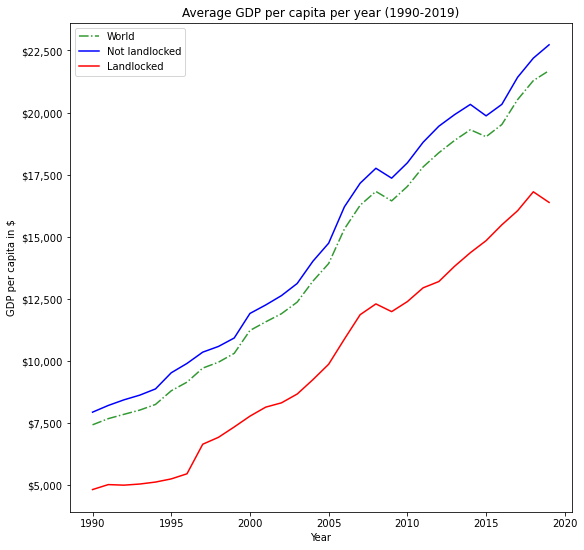

In [17]:
fig, ax = plt.subplots(1,1,figsize = (9,9))
plt.plot("date", "gdp_total", data = meangdp_year, linestyle = "dashdot", color = "green", alpha = 0.8, label = "World")
plt.plot("date", "gdp_notlandlocked", data = meangdp_year, color = "blue", label = "Not landlocked")
plt.plot("date", "gdp_landlocked", data = meangdp_year, color = "red", label = "Landlocked")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.xlabel("Year")
plt.ylabel("GDP per capita in $")
plt.title("Average GDP per capita per year (1990-2019)")
plt.legend()

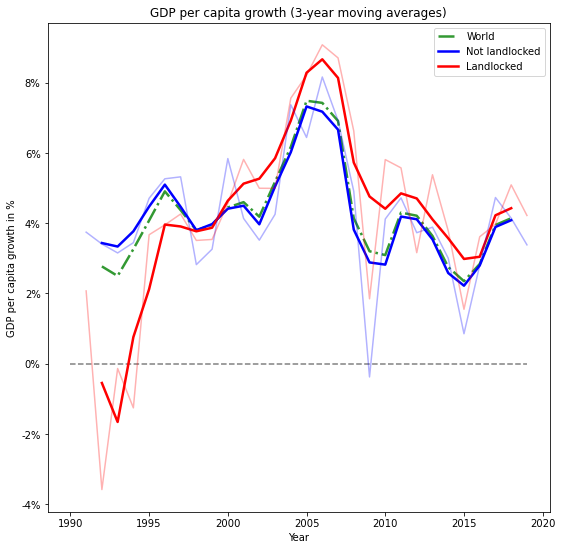

In [18]:
fig, ax = plt.subplots(1,1,figsize = (9,9))
plt.plot("date", "gdp_total_growth_ma", data = meangdp_year,linestyle = "dashdot", color = "green", linewidth = 2.5, alpha = 0.8, label = "World")
plt.plot("date", "gdp_notlandlocked_growth_ma", data = meangdp_year, color = "blue", linewidth = 2.5, label = "Not landlocked")
plt.plot("date", "gdp_landlocked_growth_ma", data = meangdp_year, color = "red", linewidth = 2.5, label = "Landlocked")
#plt.plot("date", "gdp_total_growth", data = meangdp_year, color = "green", alpha = 0.3, label = "_nolegend_")
plt.plot("date", "gdp_notlandlocked_growth", data = meangdp_year, color = "blue", alpha = 0.3, label = "_nolegend_")
plt.plot("date", "gdp_landlocked_growth", data = meangdp_year, color = "red", alpha = 0.3, label = "_nolegend_")
plt.hlines(0, min(meangdp_year["date"]), max(meangdp_year["date"]), linestyle = "dashed", color = "gray")
ax.yaxis.set_major_formatter(ticker.FuncFormatter('{:,.0%}'.format))
plt.xlabel("Year")
plt.ylabel("GDP per capita growth in %")
plt.title("GDP per capita growth (3-year moving averages)")
plt.legend()